<img src='img/nordeus_logo.png' width='500'>

# Nordeus Data Science Challenge

**Date:** 20.11.2023  
**Author:** Stefan Krstović ([mail](mailto:stefan.krstovic@outlook.com), [LinkedIn](https://www.linkedin.com/in/stefankrstovic/))\
Job Fair 2023

## Executive Summary

The notebook is my attempt at the Nordeus Data Science Challenge 2023.

During the EDA, I discovered the distributions, outliers and relationships between variables. I experimented with scaling, log transformations, encoding, and feature engineering.


The best results were derived from scaling features within each league. This approach was tested because of the nature of the challenge. Every league contains 14 clubs (rows), each ranked 1 to 14 (league_rank, which is the target). A strong team can be ranked 14th if in a really strong league, and a weak team can be ranked 1st if in a really weak league. Relative strength of a team inside of the league is more important than its absolute strength.

Instead of using the standard train_test_split, I used GroupShuffleSplit to avoid cutting across leagues.

I tested Gradient Boosting, Random Forests, XGB Regressors and XGB Rankers. I used GridSearch to find the optimal parameters. The XGBRanker gave the most promising results, edging out the XGBRegressor and the RandomForestRegressor, all having a MAE of under 2 on the test set.

After receiving the predictions I ranked them to get a rank 1 to 14 for each league. This slightly improved the scoring compared to leaving predictions as-is.

# Table of contents
1. [Introduction](#Introduction)
2. [EDA](#EDA)
3. [Train-Test split](#Train-test-split)
4. [Encoding, imputing na values, feature enginnering and standardization](#Encoding,-imputing-na-values,-feature-enginnering-and-standardization)
5. [Testing models](#Testing-models)
6. [Prediction](#Prediction)
7. [Conclusion](#Conclusion)

# Introduction
The challenge is to predict the league_rank of each footbal club. Every row in the dataset is a single club described at the last day of the previous season and its league_rank (1 to 14) at the end of the current season. 14 clubs compete in each league. Each club has a league_id showing the league it belongs to.  

The first step is to load the necessary libraries and the training dataset.  
We will then explore the data, modify it and test several algorithms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, XGBRanker
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import kstest
from statsmodels.api import qqplot

In [2]:
data_raw = pd.read_csv('jobfair_train.csv')

# EDA
The Exploratory Data Analysis will show us the main characteristics of the data.

First 5 rows:

In [3]:
data_raw.head()

,season,club_id,league_id,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,...,registration_country,registration_platform_specific,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank
0,173,6042825,2912348,2) Minnow,134,25,5.255151,4.483009,1.778801,25,...,Portugal,Flash FB Canvas,24,435,11.0,598,245,186,818,2
1,173,9620967,2912140,2) Minnow,28,23,4.962521,4.785648,-0.002687,28,...,Turkey,Android Phone,19,58,7.0,269,0,35,24,2
2,173,6045474,2912933,4) Whale,136,23,11.105782,10.511133,0.628794,28,...,Belgium,Flash FB Canvas,26,116,8.0,23180,369,444,4933,1
3,173,14187773,2910371,0) NonPayer,2,21,4.164848,4.023486,0.551904,12,...,Malaysia,Android Phone,11,22,2.0,41,43,213,126,6
4,173,13694853,2907632,0) NonPayer,5,22,3.031939,2.926029,0.690544,0,...,Italy,iOS Phone,9,0,4.0,0,16,100,147,10


Number of rows and columns respectively:

In [4]:
data_raw.shape

(55314, 23)

Column names, number of non-null values and datatypes:

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55314 entries, 0 to 55313
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   season                                   55314 non-null  int64  
 1   club_id                                  55314 non-null  int64  
 2   league_id                                55314 non-null  int64  
 3   dynamic_payment_segment                  55314 non-null  object 
 4   cohort_season                            55314 non-null  int64  
 5   avg_age_top_11_players                   55314 non-null  int64  
 6   avg_stars_top_11_players                 55314 non-null  float64
 7   avg_stars_top_14_players                 55314 non-null  float64
 8   avg_training_factor_top_11_players       55314 non-null  float64
 9   days_active_last_28_days                 55314 non-null  int64  
 10  league_match_watched_count_last_28_days  55314

Descriptive statistics:

In [6]:
data_raw.describe()

,season,club_id,league_id,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,league_match_watched_count_last_28_days,session_count_last_28_days,playtime_last_28_days,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank
count,55314.0,5.531400e+04,5.531400e+04,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000,5.531400e+04,55314.000000,55314.000000,37763.000000,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000
mean,173.0,1.210977e+07,2.909804e+06,23.409372,23.718661,4.533516,4.344776,0.584372,12.357089,3.623170,63.432169,2.955178e+07,12.411813,61.107694,3.901014,121.393897,113.133077,283.083523,307.085964,7.500000
std,0.0,3.384016e+06,2.102140e+03,42.009274,2.206240,1.204753,1.177068,0.178090,11.849102,5.906055,101.831670,5.233892e+07,6.403013,188.288285,2.625576,842.775529,3183.550398,789.250959,823.362486,4.031165
min,173.0,2.750000e+02,2.904743e+06,1.000000,18.000000,1.451697,1.354905,-1.287736,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,-4975.000000,-169.000000,0.000000,1.000000
25%,173.0,1.151105e+07,2.907961e+06,2.000000,22.000000,3.691136,3.500062,0.479571,1.000000,0.000000,1.000000,7.364150e+04,8.000000,0.000000,1.000000,0.000000,11.000000,41.000000,52.000000,4.000000
50%,173.0,1.392822e+07,2.910038e+06,4.000000,23.000000,4.481376,4.311590,0.561158,7.000000,0.000000,16.000000,6.230431e+06,12.000000,11.000000,3.000000,38.000000,29.000000,88.000000,118.000000,7.500000
75%,173.0,1.424454e+07,2.911697e+06,17.000000,25.000000,5.217394,5.021726,0.648180,27.000000,5.000000,89.000000,3.768711e+07,17.000000,63.000000,6.000000,107.000000,73.000000,243.000000,281.000000,11.000000
max,173.0,1.451477e+07,2.912940e+06,172.000000,33.000000,23.716073,20.434876,5.164494,28.000000,26.000000,1365.000000,1.340479e+09,26.000000,7443.000000,11.000000,120233.000000,744202.000000,32767.000000,32767.000000,14.000000


In [7]:
data_raw['season'].value_counts()

173    55314
Name: season, dtype: int64

All of the data is for season 173.

In [8]:
print(f"Each club in the dataset is unique: {data_raw['club_id'].nunique() == data_raw.shape[0]}")

Each club in the dataset is unique: True


In [9]:
print(f"Each league in the dataset has 14 teams: {sum(data_raw['league_id'].value_counts()==14)==data_raw.shape[0]/14},\n\
Each league in the dataset is unique: {data_raw['league_id'].nunique() == data_raw.shape[0]/14}")

Each league in the dataset has 14 teams: True,
Each league in the dataset is unique: True


In [10]:
print(f"Each league_rank (1 to 14) has the same value count: {sum(data_raw['league_rank'].value_counts()==data_raw.shape[0]/14)==14}\n\
Each league has each rank: {data_raw.groupby(['league_id', 'league_rank']).ngroups==data_raw.shape[0]}")

Each league_rank (1 to 14) has the same value count: True
Each league has each rank: True


In [11]:
data_raw.isna().sum()

season                                         0
club_id                                        0
league_id                                      0
dynamic_payment_segment                        0
cohort_season                                  0
avg_age_top_11_players                         0
avg_stars_top_11_players                       0
avg_stars_top_14_players                       0
avg_training_factor_top_11_players             0
days_active_last_28_days                       0
league_match_watched_count_last_28_days        0
session_count_last_28_days                     0
playtime_last_28_days                          0
registration_country                           0
registration_platform_specific                 0
league_match_won_count_last_28_days            0
training_count_last_28_days                    0
global_competition_level                   17551
tokens_spent_last_28_days                      0
tokens_stash                                   0
rests_stash         

Only global_competition_level has missing values (roughly 1/3 of the observations)

Columns to note based on the analysis so far:
1. **season** denominates the current season. All of the rows are for season 173. It will be dropped for this assignment.
2. **club_id** is unique for each row. There aren't any duplicates.
3. **league_id** shows that every league has exactly 14 teams and that there are no duplicate leagues.
4. **cohort_season** shows the number of seasons since the user has registered. It has a min value of 1 and a max value of 172, which is expected considering the current season is 173. However The median is just 4, and the 75th percentile is just 1/10th of the max, meaning we have a few die-hard outliers.
5. Other columns that seem to contain outliers: **avg_stars_top_11_players**, **avg_stars_top_14_players**, **avg_training_factor_top_11_players**, **league_match_watched_count_last_28_days**, **session_count_last_28_days**, **playtime_last_28_days**, **training_count_last_28_days**, **tokens_spent_last_28_days**,	**tokens_stash**, **rests_stash**,	**morale_boosters_stash**
6. **days_active_last_28_days** has min=0, 25%=1, median=7, 75%=27 and a maximum of all 28 days. It suggests that we have a large chunk of inactive users and a large chunk of incredibly active users (at least 1/4 miss no more than a day). This behavior could be used for more accurate predictions.
7. Other columns, many of which are listed in (5) show a similar story. There are some incredibly dedicated players.
8. **league_match_won_count_last_28_days** shows us that there are some teams which won all 26 games in the previous season.
9. **global_competition_level** has almost 1/3 of the data missing. It should still contain valuable information, so it won't be dropped.
10. Every **league_rank** appears the same number of times (14 possible ranks, so each counting 1/14th the length of the dataset) and every league has each of the ranks (1 to 14). There seem to be no anomalies in the target variable based on this.
11. **playtime_last_28_days** should be in minutes (as per the documentation). This doesn't make sense, as the median translates to over 11 years (and the maximum to over 1000 years). The scale would make sense if it were in milliseconds.

## Numeric columns
Numeric column characteristics and their relationship with each other and with the target.

### Correlations

<AxesSubplot:>

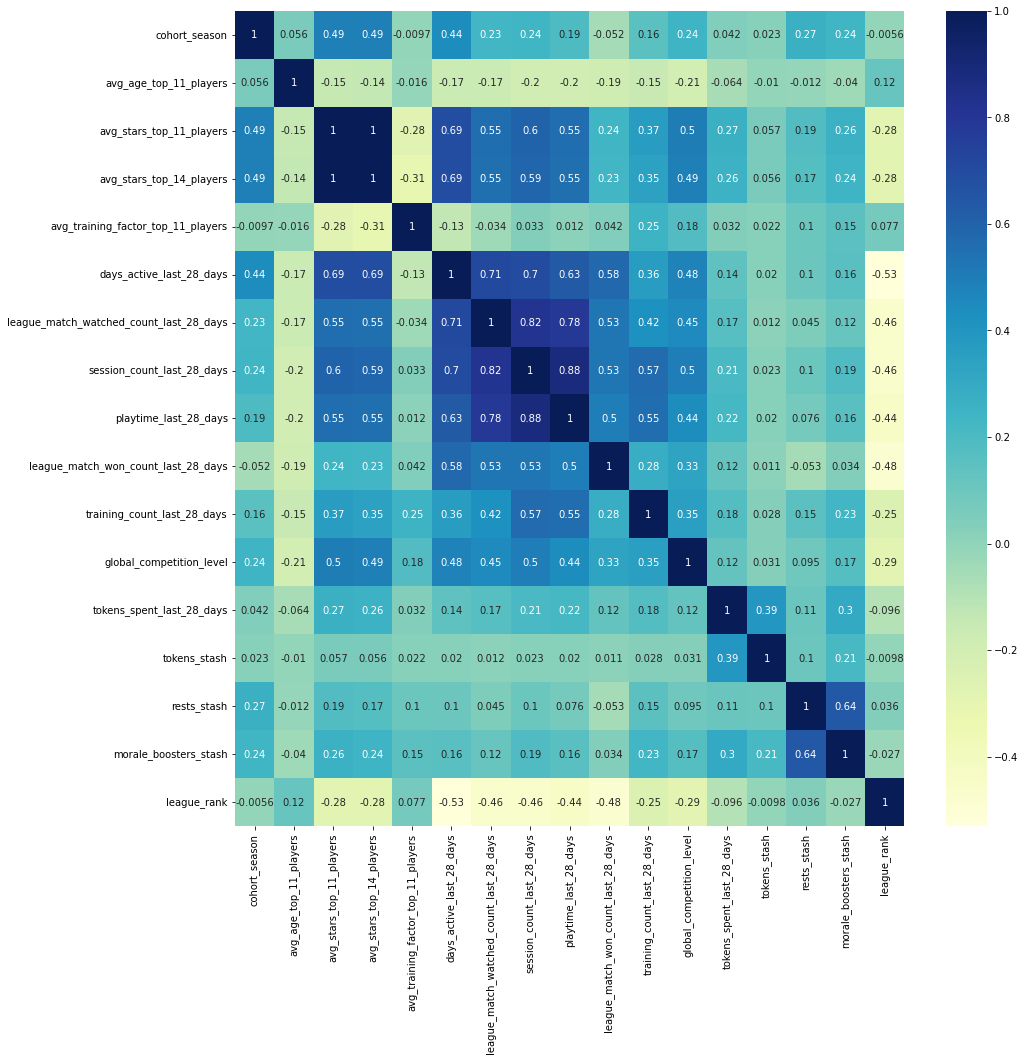

In [12]:
plt.rcParams['figure.figsize'] = 15,15

sns.heatmap(data_raw.drop(['season', 'club_id', 'league_id'], axis=1).corr(), cmap='YlGnBu', annot=True)

A list of the most correlated column pairs.

In [13]:
corr_data_raw = data_raw.drop(['season', 'club_id', 'league_id'], axis=1).corr().unstack().reset_index().sort_values(by=[0], key=abs, ascending=False)
corr_data_raw = corr_data_raw[corr_data_raw['level_0']!=corr_data_raw['level_1']].iloc[::2,]
corr_data_raw = corr_data_raw[corr_data_raw[0]>=0.5]
corr_data_raw

,level_0,level_1,0
37,avg_stars_top_11_players,avg_stars_top_14_players,0.996793
127,session_count_last_28_days,playtime_last_28_days,0.875274
109,league_match_watched_count_last_28_days,session_count_last_28_days,0.817395
142,playtime_last_28_days,league_match_watched_count_last_28_days,0.784784
91,days_active_last_28_days,league_match_watched_count_last_28_days,0.707804
92,days_active_last_28_days,session_count_last_28_days,0.702992
56,avg_stars_top_14_players,days_active_last_28_days,0.692248
39,avg_stars_top_11_players,days_active_last_28_days,0.690280
253,rests_stash,morale_boosters_stash,0.644791
141,playtime_last_28_days,days_active_last_28_days,0.633546


Regplots of 9 of the highest correlated columns:

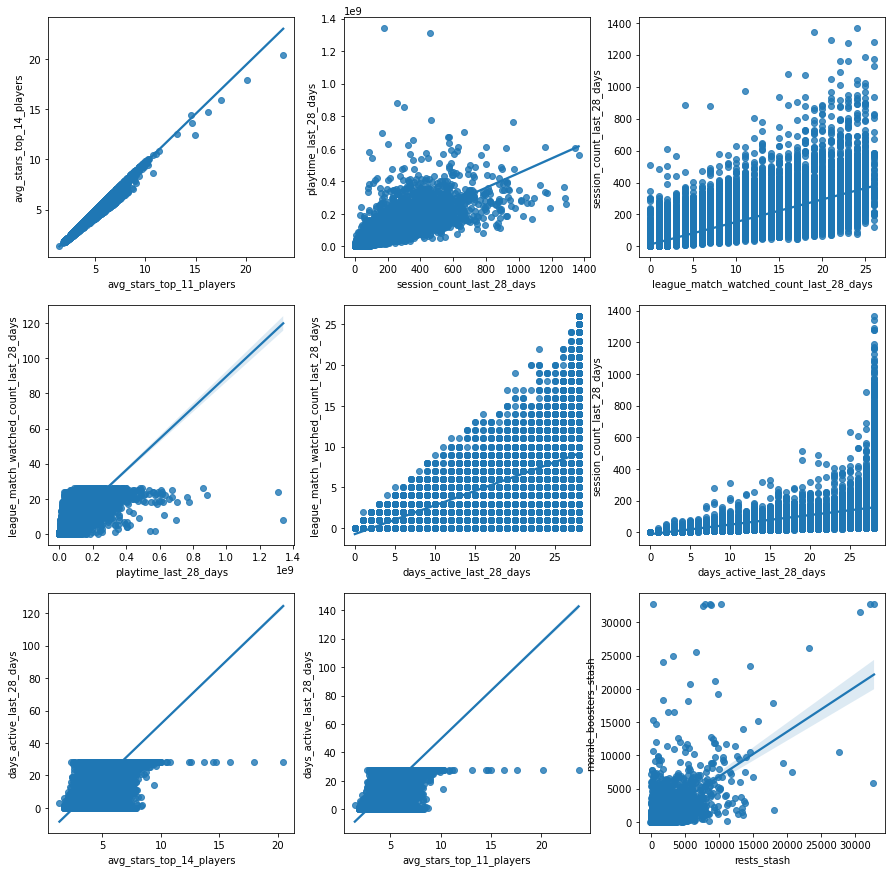

In [14]:
fig, ax = plt.subplots(3,3)

counter=0
for ind, row in corr_data_raw.iloc[:9].iterrows():
    #print(row.iloc[0])
    sns.regplot(data=data_raw, x=row.iloc[0], y=row.iloc[1], ax = ax[counter//3][counter%3])
    counter+=1

The 2 columns with the highest correlation coefficient are **avg_stars_top_11_players** and **avg_stars_top_14_players**.
In the vast majority of instances, they differ by 5% or less, and there are no instances where top14 is greater than top11, which is expected.

<AxesSubplot:>

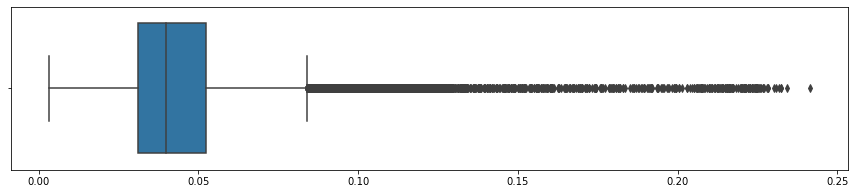

In [15]:
fig, ax = plt.subplots(figsize=(15, 3))

sns.boxplot(x=(data_raw.avg_stars_top_11_players-data_raw.avg_stars_top_14_players)/data_raw.avg_stars_top_14_players,ax=ax)

In [16]:
data_raw[data_raw.avg_stars_top_11_players<data_raw.avg_stars_top_14_players]

,season,club_id,league_id,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,...,registration_country,registration_platform_specific,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank


Plotting the distributions of numeric columns.

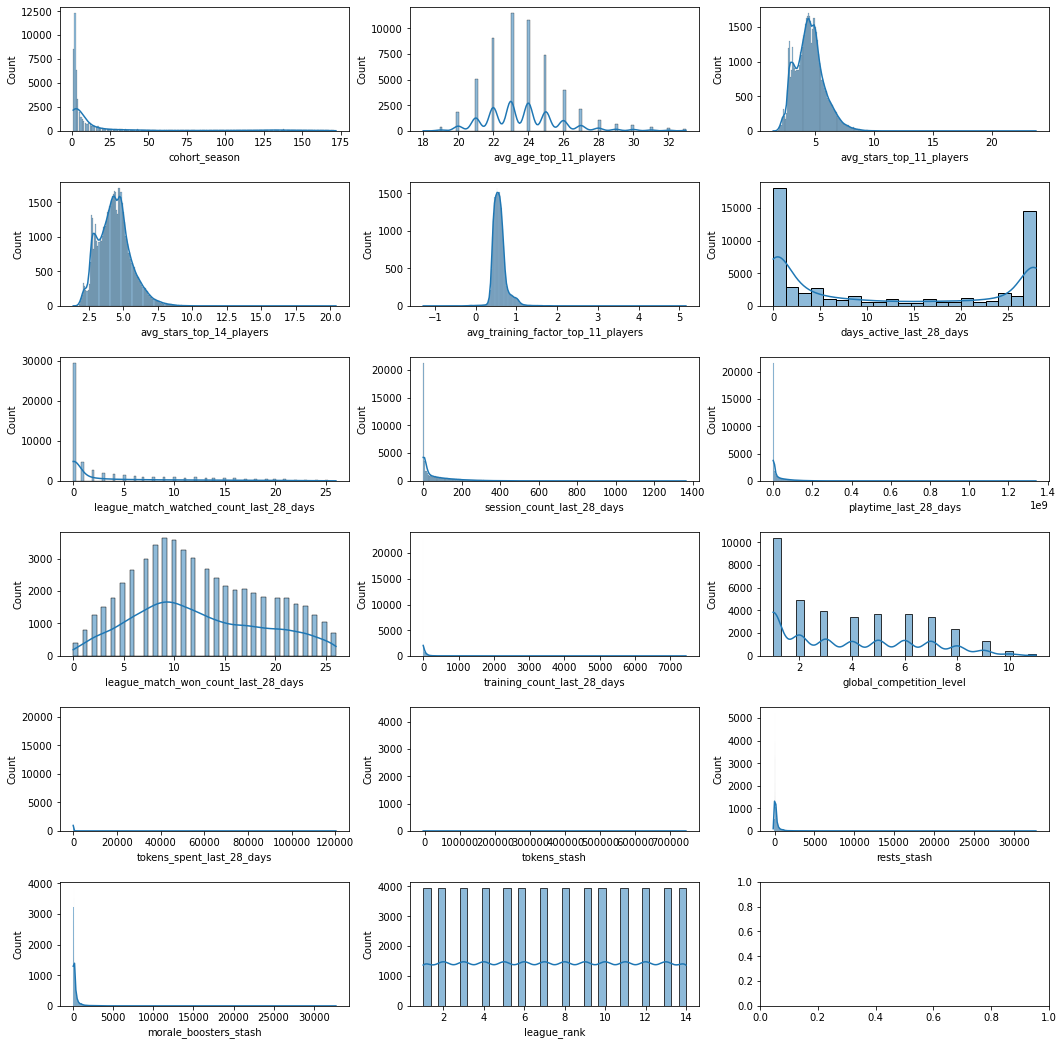

In [17]:
num_cols = data_raw.select_dtypes(exclude=['object']).drop(['season', 'club_id', 'league_id'],axis=1).columns
fig, ax = plt.subplots(nrows=6,ncols=3)
counter = 0
fig.tight_layout(pad=3)
for col in num_cols:
    #ax[counter//3][counter%3].set_text(col)
    sns.histplot(data_raw[col], ax=ax[counter//3][counter%3], kde=True)#.set(title=col)
    #if it doesn't work, change back to distplot
    counter+=1

The kstest shows us the distance between continuous column distributions and the normal distribution, and the pvalue of <0.05 shows that the lack of fit is significant (they don't adhere to the normal distribution).

In [18]:
for col in ['avg_stars_top_11_players', 'avg_stars_top_14_players', 'avg_training_factor_top_11_players']:
    print(f'{col}: {kstest(data_raw[col],"norm")}')

avg_stars_top_11_players: KstestResult(statistic=0.9807814136108899, pvalue=0.0)
avg_stars_top_14_players: KstestResult(statistic=0.9743340311550679, pvalue=0.0)
avg_training_factor_top_11_players: KstestResult(statistic=0.6200249285557362, pvalue=0.0)


The Q-Q plot is better for discrete values. The closer the blue line is to the red line, the closer the variable's distribution to normal. It's also a good way to tell which values are more frequent (eg. league_match_won_count shows that more people have a win count closer to 0, than what would be representative of the normal distribution, and less have a win count closer to the max, so it's sloped).

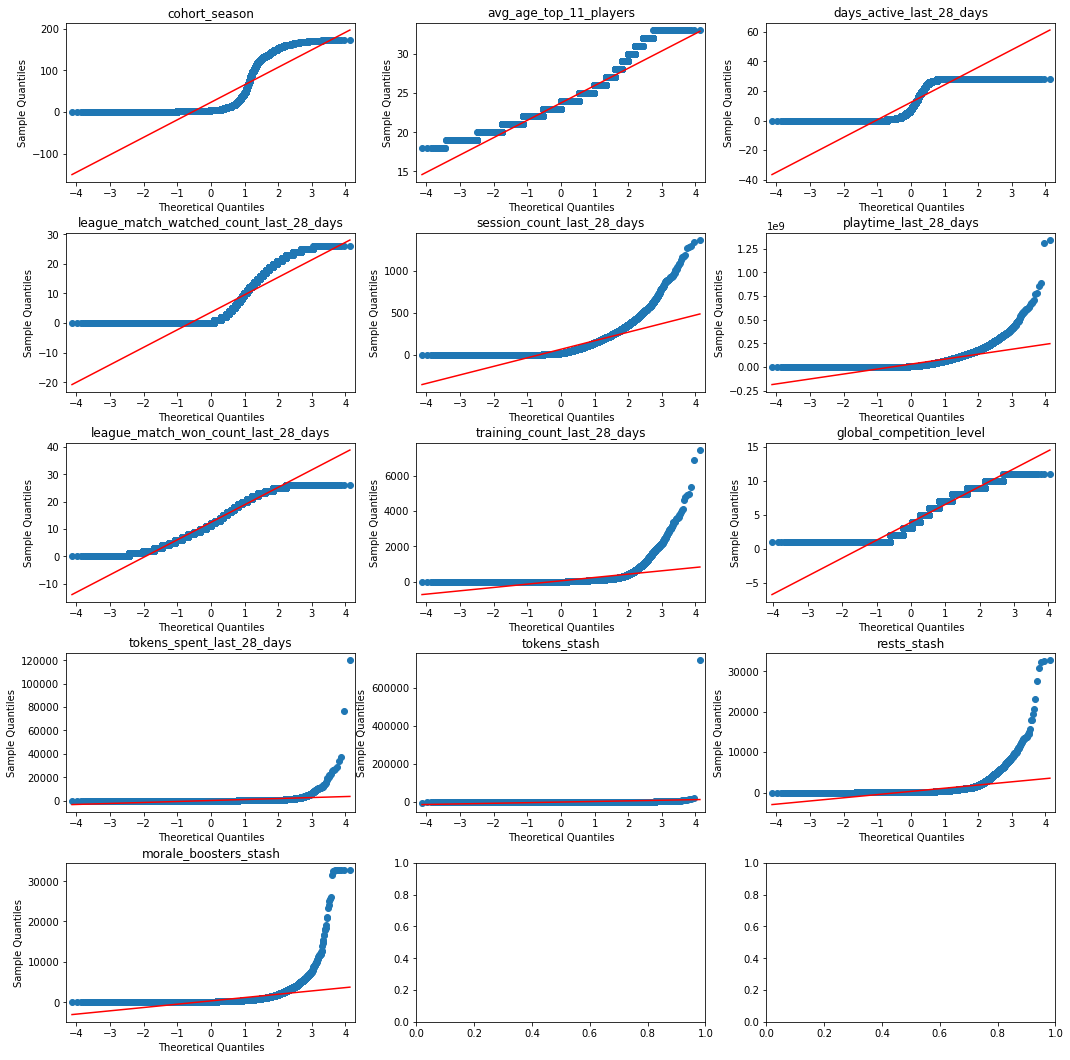

In [19]:
fig, ax = plt.subplots(5,3)
fig.tight_layout(pad=3)
for n, col in enumerate(['cohort_season', 'avg_age_top_11_players', 'days_active_last_28_days', 'league_match_watched_count_last_28_days',
            'session_count_last_28_days', 'playtime_last_28_days','league_match_won_count_last_28_days', 'training_count_last_28_days',
            'global_competition_level', 'tokens_spent_last_28_days', 'tokens_stash','rests_stash', 'morale_boosters_stash']):
    ax[n//3][n%3].set(title=col)
    qqplot(data_raw[col].dropna(), line = 's', ax=ax[n//3][n%3])

### Mutual information
MI scores roughly show how much information each variable shares with the target. The higher MI score, the better.  
The highest MI scores are for variables that show how active a player is (playtime, session count, days active, training count, ...).

<AxesSubplot:>

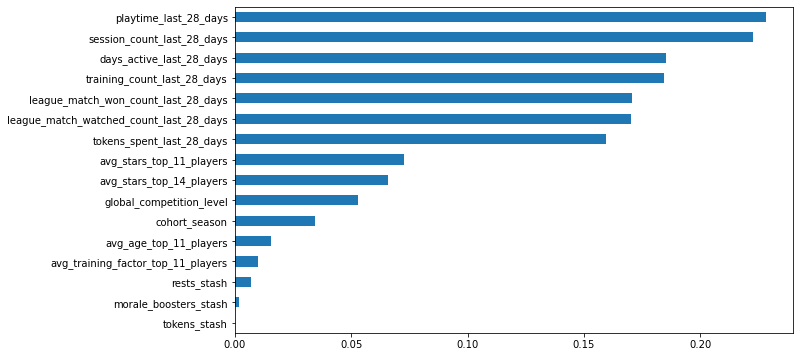

In [20]:
plt.rcParams['figure.figsize'] = 10,6
mi_cols = data_raw.select_dtypes(['int64','float64']).drop(['league_rank','club_id','league_id', 'season'], axis=1).columns

data_raw_mutual_info = data_raw.dropna().copy()
#data_raw_mutual_info['global_competition_level'] = data_raw_mutual_info.global_competition_level.fillna(data_raw_mutual_info.global_competition_level.median())

mi_scores = mutual_info_regression(data_raw_mutual_info[mi_cols], data_raw_mutual_info['league_rank'])
mi_scores = pd.Series(mi_scores, index=mi_cols)

mi_scores.sort_values().plot.barh()

The result is similar when we fill na values.

<AxesSubplot:>

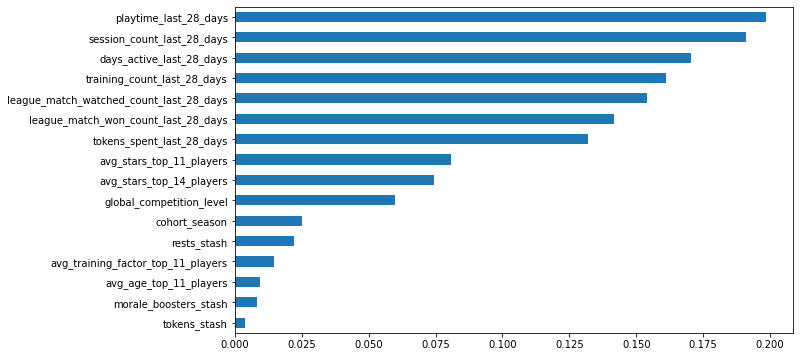

In [21]:
mi_scores = mutual_info_regression(data_raw[mi_cols].fillna(0), data_raw['league_rank'])
mi_scores = pd.Series(mi_scores, index=mi_cols)

mi_scores.sort_values().plot.barh()

### League Rank
We need to delve deeper into the only column that has missing values.

<AxesSubplot:xlabel='None-global_competition_level', ylabel='league_rank'>

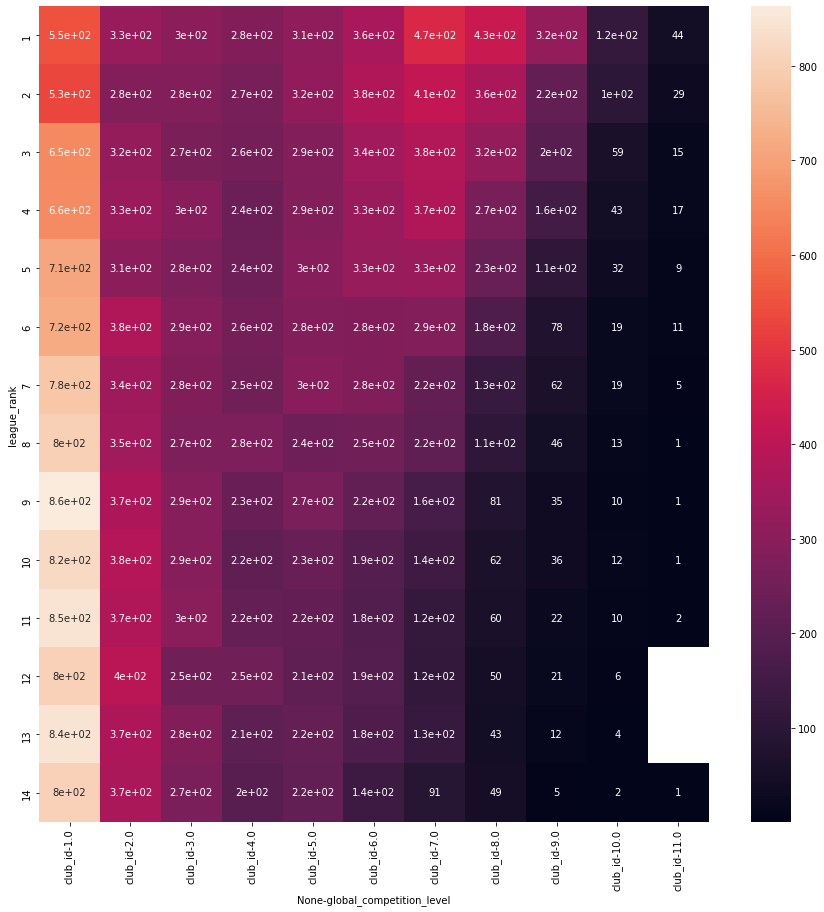

In [22]:
plt.rcParams['figure.figsize'] = 15,15
sns.heatmap(data_raw.groupby(['league_rank','global_competition_level'])['club_id'].count().reset_index().pivot(index='league_rank', columns='global_competition_level'),annot=True)

As expected, the lower the global_competition_level, the worse the league_rank.

<AxesSubplot:title={'center':'% of global_competition_level missing by league rank'}, xlabel='league_rank'>

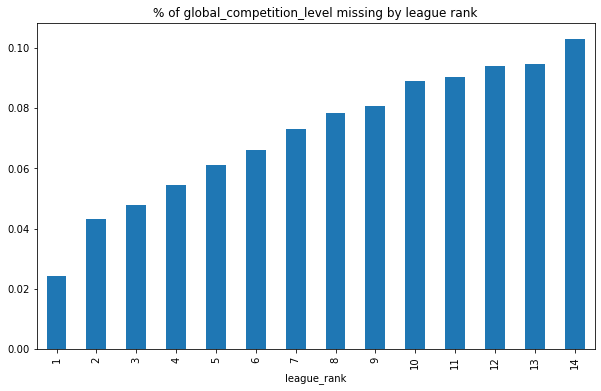

In [23]:
plt.rcParams['figure.figsize'] = 10,6
(data_raw[data_raw['global_competition_level'].isna()].groupby('league_rank')['club_id'].count()/17551).plot(kind='bar', title='% of global_competition_level missing by league rank')
#17551 is the count of missing values

The lower the rank, the higher the probability global_competition_level is missing.
If the global_competition_level is missing for a club, there is only a 2% chance that it was ranked 1st, and over 10% that it was 14th.

<AxesSubplot:title={'center':'% of leagues missing each number of global_competition_level'}>

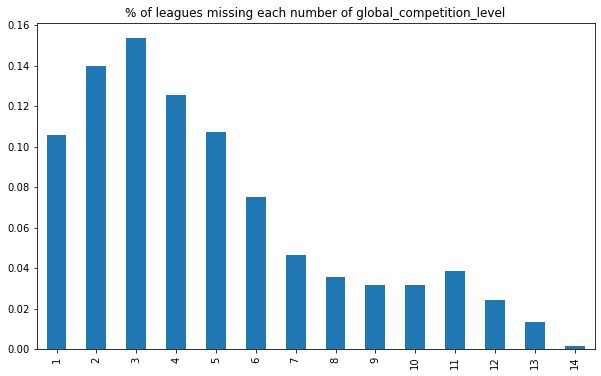

In [24]:
(data_raw[data_raw['global_competition_level'].isna()].groupby('league_id')['club_id'].count().value_counts()/3951).sort_index().plot(kind='bar', title = '% of leagues missing each number of global_competition_level')

Most leagues have <=5 levels missing.

<AxesSubplot:title={'center':'Median global competition level per league'}>

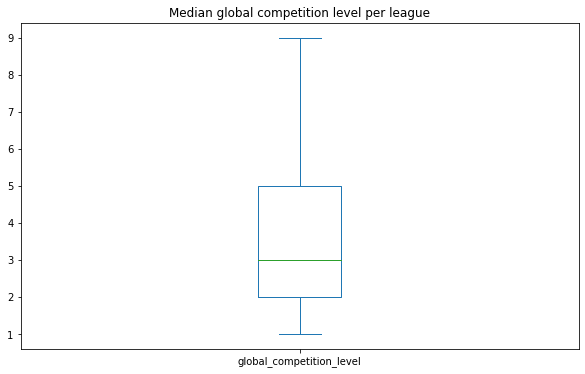

In [25]:
data_raw.groupby('league_id')['global_competition_level'].median().plot(kind='box', title = 'Median global competition level per league')

<AxesSubplot:title={'center':'Boxplot of max-min global_competition_level per league'}>

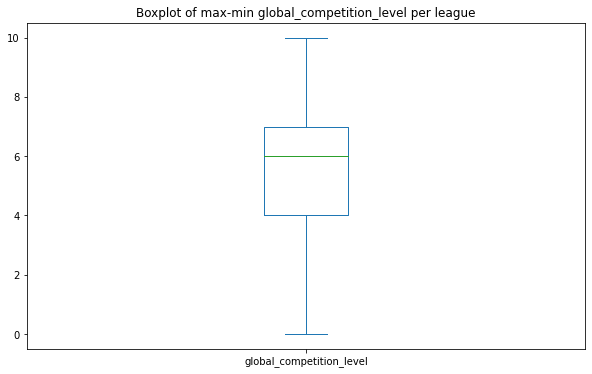

In [26]:
(data_raw[data_raw['global_competition_level'].notna()].groupby('league_id')['global_competition_level'].max()-data_raw[data_raw['global_competition_level'].notna()].groupby('league_id')['global_competition_level'].min()).sort_values(ascending=False).plot(kind='box', title = 'Boxplot of max-min global_competition_level per league')

In [27]:
data_raw['global_competition_level'].median()

3.0

In [28]:
data_raw['global_competition_level'].value_counts().sort_index()

1.0     10389
2.0      4898
3.0      3965
4.0      3409
5.0      3701
6.0      3651
7.0      3458
8.0      2374
9.0      1327
10.0      455
11.0      136
Name: global_competition_level, dtype: int64

<AxesSubplot:title={'center':'gcl=4'}, xlabel='league_rank'>

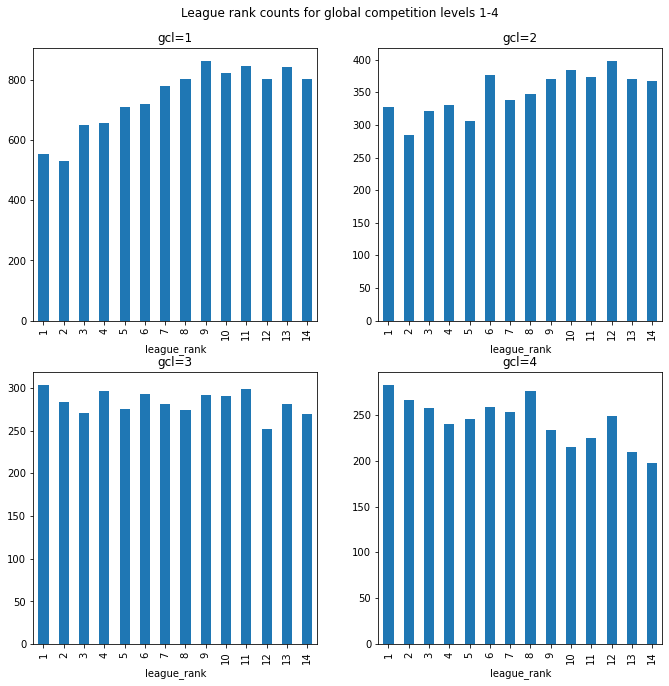

In [29]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
fig.suptitle('League rank counts for global competition levels 1-4', y=0.95)
fig.tight_layout(pad = 3)

data_raw[data_raw['global_competition_level']==1].groupby('league_rank')['club_id'].count().plot(kind='bar', title='gcl=1', ax=ax[0][0])
data_raw[data_raw['global_competition_level']==2].groupby('league_rank')['club_id'].count().plot(kind='bar', title='gcl=2', ax=ax[0][1])
data_raw[data_raw['global_competition_level']==3].groupby('league_rank')['club_id'].count().plot(kind='bar', title='gcl=3', ax=ax[1][0])
data_raw[data_raw['global_competition_level']==4].groupby('league_rank')['club_id'].count().plot(kind='bar', title='gcl=4', ax=ax[1][1])

The median for global_competition_level is 3. There are no significant differences in league ranks for clubs in this range.  
If the level is reduced (1 and 2), more teams have a lower rank, and if it's increased (4), more teams have a higher rank.  

The missing values belong to mostly poorly ranked teams. If we impute them to the median (3), we could create a problem, as level 3 teams before imputation would have uniform ranks, and after imputation would have weaker ranks. We will test if values below 3 are a better fit.

cohort_season                                  AxesSubplot(0.125,0.71587;0.168478x0.16413)
avg_age_top_11_players                      AxesSubplot(0.327174,0.71587;0.168478x0.16413)
avg_stars_top_11_players                    AxesSubplot(0.529348,0.71587;0.168478x0.16413)
avg_stars_top_14_players                    AxesSubplot(0.731522,0.71587;0.168478x0.16413)
avg_training_factor_top_11_players            AxesSubplot(0.125,0.518913;0.168478x0.16413)
days_active_last_28_days                   AxesSubplot(0.327174,0.518913;0.168478x0.16413)
league_match_watched_count_last_28_days    AxesSubplot(0.529348,0.518913;0.168478x0.16413)
session_count_last_28_days                 AxesSubplot(0.731522,0.518913;0.168478x0.16413)
playtime_last_28_days                         AxesSubplot(0.125,0.321957;0.168478x0.16413)
league_match_won_count_last_28_days        AxesSubplot(0.327174,0.321957;0.168478x0.16413)
training_count_last_28_days                AxesSubplot(0.529348,0.321957;0.168478x0.16413)

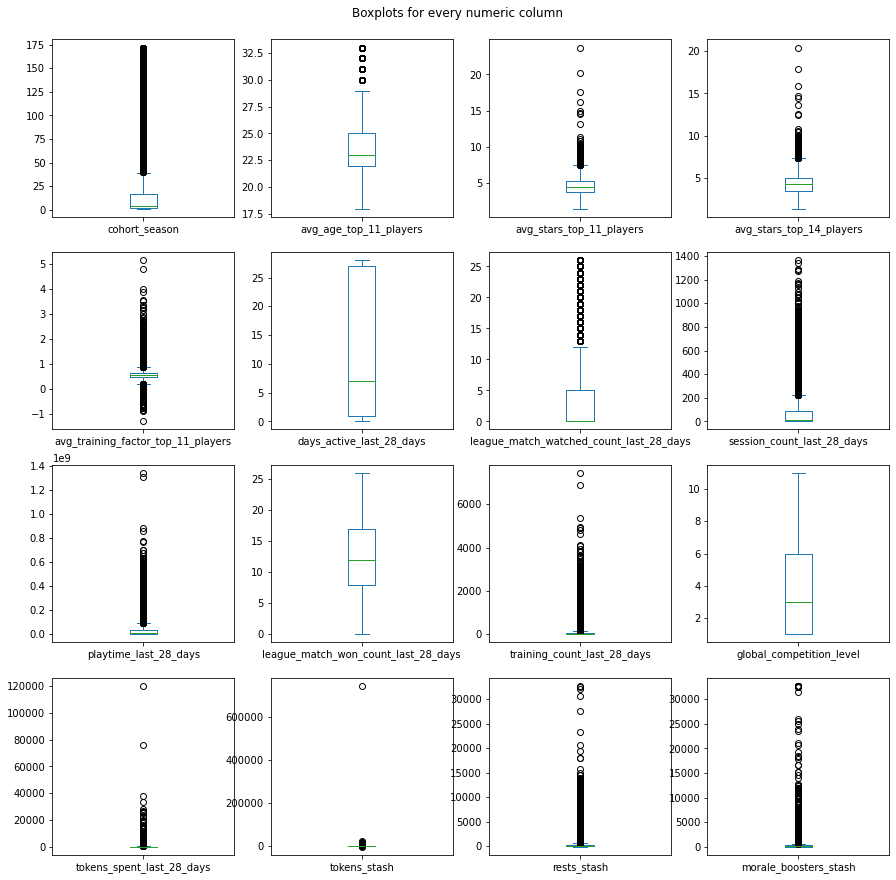

In [30]:
fig, ax = plt.subplots(4,4, figsize = (15,15))
fig.suptitle('Boxplots for every numeric column', y=0.91)

data_raw.select_dtypes(exclude='object').drop(['club_id','league_id','season','league_rank'],axis=1).plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 6),
    ax=ax
)

There are some columns with significant outliers. We will attempt to log1p transform them later to see whether we get positive results.

## Categorical columns

### dynamic_payment_segment
There is a clear relationship between the payment segment and the league rank (the more people pay, the higher their rank).  
There higher the payment segment, the lower the number of players.

Text(0.5, 1.0, 'Average league rank for each dynamic_payment_segment')

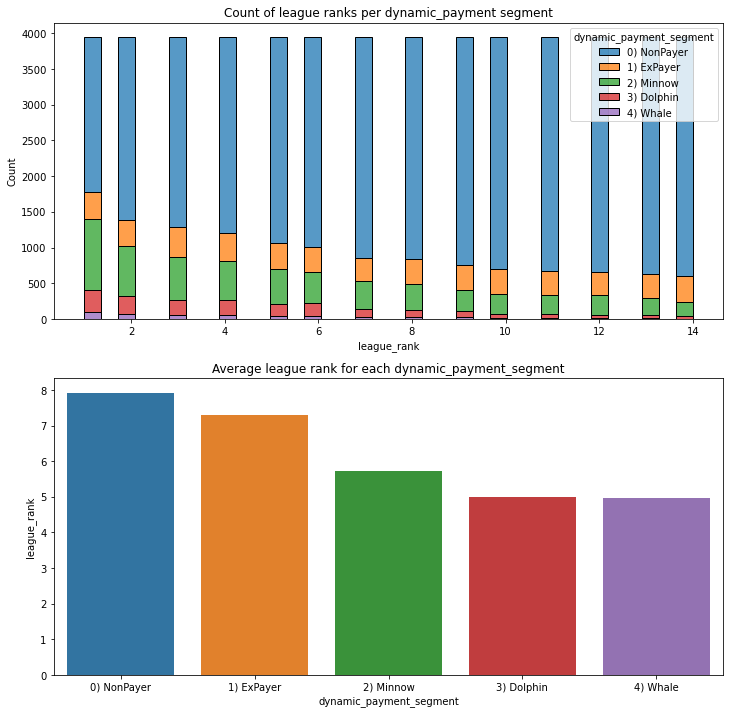

In [31]:
categorical_cols = data_raw.select_dtypes('object').columns
fig, ax = plt.subplots(2, figsize=(12,12))

sns.histplot(data=data_raw.sort_values(by='dynamic_payment_segment'), x='league_rank', hue='dynamic_payment_segment', multiple='stack', ax=ax[0])
sns.barplot(data = data_raw.groupby('dynamic_payment_segment')['league_rank'].mean().reset_index(), x='dynamic_payment_segment',y='league_rank', ax=ax[1])

ax[0].set_title('Count of league ranks per dynamic_payment segment')
ax[1].set_title('Average league rank for each dynamic_payment_segment')

The differences between each payment segment are not uniform, so both the OrdinalEncoder and the OneHotEncoder will be tested.

### registration_country
The more players the country has, the less it deviates from the average league rank. This is expected.  
There are too many categories for encoding, so this column will be dropped.  
However, a target encoding technique could provide some additional information with a sufficiently large dataset.

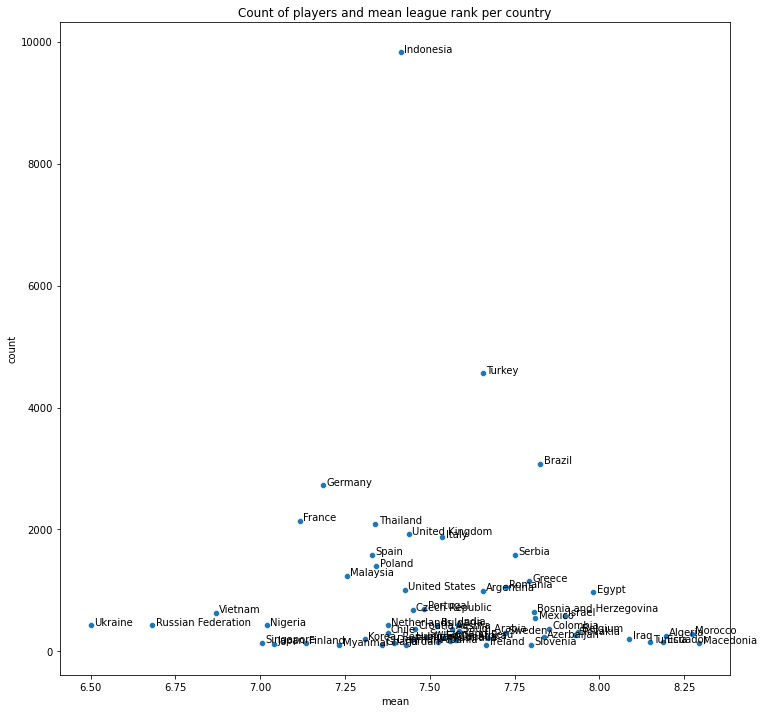

In [32]:
plt.rcParams['figure.figsize'] = 12,12
data_reg_country_league_rank_stats = data_raw.groupby('registration_country')['league_rank'].agg(['mean', 'count'])
data_reg_country_league_rank_stats = data_reg_country_league_rank_stats[data_reg_country_league_rank_stats['count']>100]
ax = sns.scatterplot(data=data_reg_country_league_rank_stats, x='mean', y='count')
ax.set_title('Count of players and mean league rank per country')
for i, row in data_reg_country_league_rank_stats.iterrows():
    ax.text(row[0]+0.01, row[1]+5, i)

### registration_platform_specific
This shows which platform each user created their account with. There are no meaningful differences between platforms, and many users created their accounts years ago and have since switched equipment, so the column will be dropped.  
Maybe the more suitable column would be 'current predominant platform'.

<AxesSubplot:xlabel='league_rank', ylabel='registration_platform_specific'>

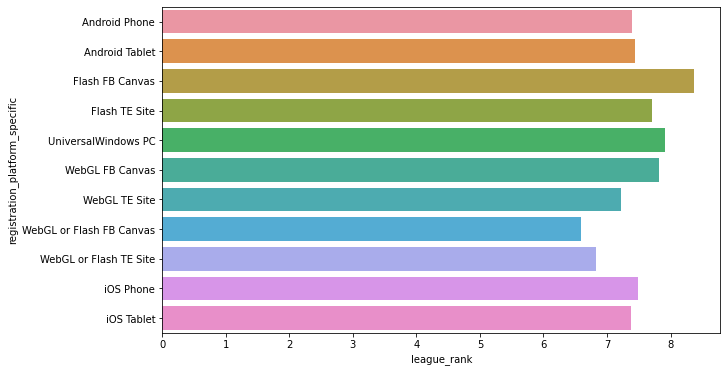

In [33]:
plt.rcParams['figure.figsize'] = 10,6
df_platform_rank_count = data_raw.groupby('registration_platform_specific')['league_rank'].mean().reset_index()
sns.barplot(data=df_platform_rank_count,y='registration_platform_specific', x='league_rank', orient='h')

# Train test split
We will split the data into training and test sets. We can use the test set to gauge how well our modifications and changes are doing with unseen data.

**Important:** Because the nature of the challenge, we will be using GroupShuffleSplit instead of the train_test_split.
The former won't cut across leagues.

In [34]:
data_for_split = data_raw.copy()
gss = GroupShuffleSplit(test_size=0.25, n_splits=1).split(data_for_split, groups=data_for_split['league_id'])

train_ind, test_ind = next(gss)
data_train = data_for_split.loc[train_ind]#.drop('league_id', axis=1)
data_test = data_for_split.loc[test_ind]

In [35]:
num_cols_to_drop = ['season','club_id','league_id','league_rank']
X_train = data_train.select_dtypes(exclude='object').drop(num_cols_to_drop,axis=1)
X_test = data_test.select_dtypes(exclude='object').drop(num_cols_to_drop,axis=1)
y_train = data_train['league_rank']
y_test = data_test['league_rank']

# Encoding, imputing na values, feature enginnering and standardization
We will modify our data to see what yields the best result.  
The following function will help us compare errors.

In [36]:
def print_mae(X_train, y_train, X_test, y_test, description:str = '', model = XGBRegressor()):
    model.fit(X_train, y_train)
    print(f'MAE {description} - Train: {mean_absolute_error(model.predict(X_train),y_train)} Test: {mean_absolute_error(model.predict(X_test),y_test)}')

## Encoding
We will thest the OrdinalEncoder and the OneHotEncoder

In [37]:
oe = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1)

oe_cols_data_train = pd.DataFrame(oe.fit_transform(data_train['dynamic_payment_segment'].values.reshape(-1,1)),index=data_train.index)
oe_cols_data_test = pd.DataFrame(oe.transform(data_test['dynamic_payment_segment'].values.reshape(-1,1)), index=data_test.index)

In [38]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

oh_cols_data_train = pd.DataFrame(ohe.fit_transform(data_train['dynamic_payment_segment'].values.reshape(-1,1)), index=data_train.index)
oh_cols_data_train.columns = ['0', '1', '2', '3','4']

oh_cols_data_test = pd.DataFrame(ohe.transform(data_test['dynamic_payment_segment'].values.reshape(-1,1)), index=data_test.index)
oh_cols_data_test.columns = ['0', '1', '2', '3','4']

In [39]:
print_mae(X_train, y_train, X_test, y_test, 'no encoding')

x_tr = pd.concat([X_train, oe_cols_data_train], axis=1)
x_te = pd.concat([X_test, oe_cols_data_test], axis=1)
print_mae(x_tr, y_train, x_te, y_test, 'ordinal encoding')

x_tr = pd.concat([X_train, oh_cols_data_train], axis=1)
x_te = pd.concat([X_test, oh_cols_data_test], axis=1)
print_mae(x_tr, y_train, x_te, y_test, 'one hot encoding')

x_tr = pd.concat([X_train, oh_cols_data_train.drop('0', axis=1)], axis=1)
x_te = pd.concat([X_test, oh_cols_data_test.drop('0', axis=1)], axis=1)
print_mae(x_tr, y_train, x_te, y_test, 'one hot encoding (drop first)')

MAE no encoding - Train: 1.988394087775094 Test: 2.372354508076507
MAE ordinal encoding - Train: 1.9767731379357112 Test: 2.370401071743289
MAE one hot encoding - Train: 1.96933320771376 Test: 2.3765166862619322
MAE one hot encoding (drop first) - Train: 1.959235506821678 Test: 2.3779275227562153


In [40]:
print_mae(X_train.fillna(0), y_train, X_test.fillna(0), y_test, 'no encoding', RandomForestRegressor())

x_tr = pd.concat([X_train.fillna(0), oe_cols_data_train], axis=1)
x_te = pd.concat([X_test.fillna(0), oe_cols_data_test], axis=1)
print_mae(x_tr, y_train, x_te, y_test, 'ordinal encoding', RandomForestRegressor())

x_tr = pd.concat([X_train.fillna(0), oh_cols_data_train], axis=1)
x_te = pd.concat([X_test.fillna(0), oh_cols_data_test], axis=1)
print_mae(x_tr, y_train, x_te, y_test, 'one hot encoding', RandomForestRegressor())

x_tr = pd.concat([X_train.fillna(0), oh_cols_data_train.drop('0', axis=1)], axis=1)
x_te = pd.concat([X_test.fillna(0), oh_cols_data_test.drop('0', axis=1)], axis=1)
print_mae(x_tr, y_train, x_te, y_test, 'one hot encoding (drop first)', RandomForestRegressor())

MAE no encoding - Train: 0.8870307603297816 Test: 2.3733588779641415


C:\Users\stefa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\stefa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\stefa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


MAE ordinal encoding - Train: 0.8870806614917315 Test: 2.371425679583574
MAE one hot encoding - Train: 0.888215129453739 Test: 2.366998987854251
MAE one hot encoding (drop first) - Train: 0.8875946193529723 Test: 2.3717965587044536


We will use OneHotEncoding and won't drop the first column.

## NA Values
As discussed, the median may not be the best value for global_competition_level.  
We will test the median along with some other fixed values, and a dynamic median for each league, and also see whether adding a flag missing_gpl will help.

In [41]:
na_replacements = np.nan, 0, 1, 2, X_train['global_competition_level'].median()

print('XGBRegressor')
for val in na_replacements:
    x_tr = X_train.fillna(val)
    x_te = X_test.fillna(val)
    print_mae(x_tr, y_train, x_te, y_test, f'filled na {val}')

print('RandomForestRegressor')
for val in na_replacements:
    if np.isnan(val):
        continue
    x_tr = X_train.fillna(val)
    x_te = X_test.fillna(val)
    print_mae(x_tr, y_train, x_te, y_test, f'filled na {val}', RandomForestRegressor())

XGBRegressor
MAE filled na nan - Train: 1.988394087775094 Test: 2.372354508076507
MAE filled na 0 - Train: 1.9905283221488494 Test: 2.3775888841885786
MAE filled na 1 - Train: 1.9839362284360513 Test: 2.3808535877841446
MAE filled na 2 - Train: 1.9914899847859213 Test: 2.3717395325399777
MAE filled na 3.0 - Train: 1.9800001366529951 Test: 2.3806498424899307
RandomForestRegressor
MAE filled na 0 - Train: 0.8868034328142326 Test: 2.3731578947368424
MAE filled na 1 - Train: 0.8877161178342413 Test: 2.368131145170619
MAE filled na 2 - Train: 0.8872469986982305 Test: 2.3744425968768073
MAE filled na 3.0 - Train: 0.8881442553396652 Test: 2.364553932909196


In [42]:
x_tr = X_train.copy()
x_te = X_test.copy()

x_tr['global_competition_level'] = x_tr['global_competition_level'].fillna(data_train.groupby('league_id')['global_competition_level'].transform('median'))
x_te['global_competition_level'] = x_te['global_competition_level'].fillna(data_train.groupby('league_id')['global_competition_level'].transform('median'))

x_tr = x_tr.fillna(1)
x_te = x_te.fillna(1)

print_mae(x_tr, y_train, x_te, y_test, f'na dynamic median XGBoost')
print_mae(x_tr, y_train, x_te, y_test, f'na dynamic median RandomForestRegressor', RandomForestRegressor())

MAE na dynamic median XGBoost - Train: 1.981638920435904 Test: 2.3913536439704384
MAE na dynamic median RandomForestRegressor - Train: 0.8874755315558555 Test: 2.3836574609600927


In [43]:
x_tr = X_train.drop('global_competition_level',axis=1).copy()
x_tr['missing_global_competition_level'] = X_train['global_competition_level'].isna().astype('int64')
x_te = X_test.drop('global_competition_level',axis=1).copy()
x_te['missing_global_competition_level'] = X_test['global_competition_level'].isna().astype('int64')

print('XGBRegressor')
print_mae(X_train.fillna(0), y_train, X_test.fillna(0), y_test, 'missing = 0')
print_mae(X_train.drop('global_competition_level',axis=1), y_train, X_test.drop('global_competition_level',axis=1), y_test, 'without global_competition_level')
print_mae(x_tr, y_train, x_te, y_test, 'with missing_global_competition_level')
print_mae(x_tr.fillna(0), y_train, x_te.fillna(0), y_test, 'with missing = 0 and flag')

print('RandomForestRegressor')
print_mae(X_train.fillna(0), y_train, X_test.fillna(0), y_test, 'missing = 0', RandomForestRegressor())
print_mae(X_train.drop('global_competition_level',axis=1), y_train, X_test.drop('global_competition_level',axis=1), y_test, 'without global_competition_level', RandomForestRegressor())
print_mae(x_tr, y_train, x_te, y_test, 'with missing_global_competition_level', RandomForestRegressor())
print_mae(x_tr.fillna(0), y_train, x_te.fillna(0), y_test, 'with missing = 0 and flag', RandomForestRegressor())

XGBRegressor
MAE missing = 0 - Train: 1.9905283221488494 Test: 2.3775888841885786
MAE without global_competition_level - Train: 1.9963256659881656 Test: 2.3821148349014214
MAE with missing_global_competition_level - Train: 1.9837316616738863 Test: 2.3686760096445014
MAE with missing = 0 and flag - Train: 1.9837316616738863 Test: 2.3686760096445014
RandomForestRegressor
MAE missing = 0 - Train: 0.8891475820837953 Test: 2.37619939271255
MAE without global_competition_level - Train: 0.8886926859842823 Test: 2.3734441873915557
MAE with missing_global_competition_level - Train: 0.8879376597078249 Test: 2.3726163967611336
MAE with missing = 0 and flag - Train: 0.8886078299021263 Test: 2.373137651821862


The missing values will be set to 0, and no flag will be used.

## Feature engineering
A new column is supposed to give a rough estimate of variation between players of each club.
Example: 11 players have 10 avg stars (110 in total). 14 players have 9 avg stars (126 in total). The last 3 players contribute only 16 (126-110) stars, meaning 5,33 on average. Maybe the variation between players will reveal a significant trend.

In [44]:
x_tr, x_te = X_train.copy(), X_test.copy()
x_tr = x_tr.fillna(0)
x_te = x_te.fillna(0)
x_tr['player_star_variation'] = x_tr['avg_stars_top_11_players']-(x_tr['avg_stars_top_14_players']*14-x_tr['avg_stars_top_11_players']*11)/3
x_te['player_star_variation'] = x_te['avg_stars_top_11_players']-(x_te['avg_stars_top_14_players']*14-x_te['avg_stars_top_11_players']*11)/3

In [45]:
print_mae(x_tr, y_train, x_te, y_test, 'player_star_variation XGB')
print_mae(x_tr.drop('avg_stars_top_14_players',axis=1), y_train, x_te.drop('avg_stars_top_14_players',axis=1), y_test, 'player_star_variation no top 14 XGB')
print_mae(X_train.drop('avg_stars_top_14_players', axis=1), y_train, X_test.drop('avg_stars_top_14_players',axis=1),y_test,'no player star var and no top 14 XGB')

print_mae(x_tr, y_train, x_te, y_test, 'player_star_variation forest', RandomForestRegressor())
print_mae(x_tr.drop('avg_stars_top_14_players',axis=1), y_train, x_te.drop('avg_stars_top_14_players',axis=1), y_test, 'player_star_variation no top 14 Forest', RandomForestRegressor())
print_mae(X_train.drop('avg_stars_top_14_players', axis=1).fillna(0), y_train, X_test.drop('avg_stars_top_14_players',axis=1).fillna(0),y_test,'no player star var and no top 14 Forest', RandomForestRegressor())

MAE player_star_variation XGB - Train: 1.9604711120783045 Test: 2.3720192644608296
MAE player_star_variation no top 14 XGB - Train: 1.9862194698980888 Test: 2.3727237192861104
MAE no player star var and no top 14 XGB - Train: 2.0061677659591295 Test: 2.3771293430878395
MAE player_star_variation forest - Train: 0.8861122896678078 Test: 2.3624884326200117
MAE player_star_variation no top 14 Forest - Train: 0.8877009305240826 Test: 2.367815211104685
MAE no player star var and no top 14 Forest - Train: 0.8908326503061568 Test: 2.37084008097166


The new variable slightly improves the MAE, so it will be kept.

## Standardization
We will first try to transform the columns with log1p, and then to min-max scale them for each league.  

### log1p

In [46]:
cols_to_transform = ['cohort_season','session_count_last_28_days', 'playtime_last_28_days', 'training_count_last_28_days','tokens_spent_last_28_days','tokens_stash','rests_stash','morale_boosters_stash']

In [47]:
x_tr, x_te = X_train.copy(), X_test.copy()
print_mae(x_tr, y_train, x_te, y_test, 'original cols XGB')
print_mae(x_tr.fillna(0), y_train, x_te.fillna(0), y_test, 'original cols forest', RandomForestRegressor())
x_tr[cols_to_transform] = np.log1p(x_tr[cols_to_transform])
x_tr[cols_to_transform] = x_tr[cols_to_transform].fillna(0)

x_te[cols_to_transform] = np.log1p(x_te[cols_to_transform])
x_te[cols_to_transform] = x_te[cols_to_transform].fillna(0)

print_mae(x_tr, y_train, x_te, y_test, 'transformed cols XGB')
print_mae(x_tr.fillna(0), y_train, x_te.fillna(0), y_test, 'transformed cols forest', RandomForestRegressor())

MAE original cols XGB - Train: 1.988394087775094 Test: 2.372354508076507
MAE original cols forest - Train: 0.8898073863362423 Test: 2.3702747252747254


C:\Users\stefa\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
C:\Users\stefa\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


MAE transformed cols XGB - Train: 1.9784006851068672 Test: 2.3754791150401746
MAE transformed cols forest - Train: 0.8883306012246275 Test: 2.3725932620011574


log1p didn't produce significant results.

### min-max per league

In [48]:
min_ = data_train.groupby('league_id').transform('min').select_dtypes(exclude='object').drop(['season','club_id','league_rank'],axis=1)
max_ = data_train.groupby('league_id').transform('max').select_dtypes(exclude='object').drop(['season','club_id','league_rank'],axis=1)

x_tr = ((X_train-min_)/(max_-min_)).fillna(0)

min_test = data_test.groupby('league_id').transform('min').select_dtypes(exclude='object').drop(['season','club_id','league_rank'],axis=1)
max_test = data_test.groupby('league_id').transform('max').select_dtypes(exclude='object').drop(['season','club_id','league_rank'],axis=1)
x_te = ((X_test-min_test)/(max_test-min_test)).fillna(0)

In [49]:
print_mae(x_tr, y_train, x_te, y_test, 'cols scaled per league XGB')
print_mae(x_tr.fillna(0), y_train, x_te.fillna(0), y_test, 'cols scaled per league forest', RandomForestRegressor())

MAE cols scaled per league XGB - Train: 1.701052519640579 Test: 2.146073184254595
MAE cols scaled per league forest - Train: 0.7989438792729376 Test: 2.140864661654135


This produced a noticeably better result.

# Testing models
We will first create the final X_train and X_test, and then test several models.  
We will pick their hyperparameters using GridSearchCV.  
The XGBRanker will be run based on the best hyperparameters of the XGBRegressor.

In [50]:
X_train['player_star_variation'] = X_train['avg_stars_top_11_players']-(X_train['avg_stars_top_14_players']*14-X_train['avg_stars_top_11_players']*11)/3
X_test['player_star_variation'] = X_test['avg_stars_top_11_players']-(X_test['avg_stars_top_14_players']*14-X_test['avg_stars_top_11_players']*11)/3

data_train['player_star_variation'] = X_train['player_star_variation']
data_test['player_star_variation'] = X_test['player_star_variation']

min_ = data_train.groupby('league_id').transform('min').select_dtypes(exclude='object').drop(['season','club_id','league_rank'],axis=1)
max_ = data_train.groupby('league_id').transform('max').select_dtypes(exclude='object').drop(['season','club_id','league_rank'],axis=1)
min_test = data_test.groupby('league_id').transform('min').select_dtypes(exclude='object').drop(['season','club_id','league_rank'],axis=1)
max_test = data_test.groupby('league_id').transform('max').select_dtypes(exclude='object').drop(['season','club_id','league_rank'],axis=1)

min_, max_, min_test, max_test = min_.fillna(0), max_.fillna(0), min_test.fillna(0), max_test.fillna(0)

X_train = ((X_train-min_)/(max_-min_)).fillna(0)
X_test = ((X_test-min_test)/(max_test-min_test)).fillna(0)
X_train = X_train.replace({np.nan: 0.0, np.inf: 0.0, -np.inf: 0.0})
X_test = X_test.replace({np.nan: 0.0, np.inf: 0.0, -np.inf: 0.0})

X_train = pd.concat([X_train, oh_cols_data_train], axis=1)
X_test = pd.concat([X_test, oh_cols_data_test], axis=1)

In [51]:
print_mae(X_train,y_train,X_test,y_test, 'all columns XGB')
print_mae(X_train,y_train,X_test,y_test, 'all columns forest', RandomForestRegressor())

MAE all columns XGB - Train: 1.6923968343757574 Test: 2.1346126298203054
MAE all columns forest - Train: 0.7947227713225014 Test: 2.128374060150376


In [52]:
models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    #'XGBRanker': XGBRanker(),
    'RandomForestRegressor': RandomForestRegressor()
}

params = {
    'GradientBoostingRegressor' : {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
    }
    ,
    'XGBRegressor' : {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_jobs': [-1]
    }
    ,
    'RandomForestRegressor' : {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 25],
    'n_jobs': [-1]
    }
}

In [53]:
results = {}
for k, v in models.items():
    group_cv = GroupKFold(n_splits=5)
    grid_search = GridSearchCV(v, params[k], scoring = 'neg_mean_absolute_error', cv=group_cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train,y_train,groups=data_train['league_id'])
    results[k] = {'best_params' : grid_search.best_params_, 'best_score' : grid_search.best_score_}
results

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'GradientBoostingRegressor': {'best_params': {'learning_rate': 0.1,
   'max_depth': 5,
   'n_estimators': 150},
  'best_score': -2.11648948673903},
 'XGBRegressor': {'best_params': {'learning_rate': 0.1,
   'max_depth': 7,
   'n_estimators': 100,
   'n_jobs': -1},
  'best_score': -2.112945163577448},
 'RandomForestRegressor': {'best_params': {'max_depth': 25,
   'n_estimators': 200,
   'n_jobs': -1},
  'best_score': -2.1442498466466136}}

In some cases the highest possible parameter was chosen. Because of that, we will expand our grid where necessary.

In [54]:
models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    #'XGBRanker': XGBRanker(),
    'RandomForestRegressor': RandomForestRegressor()
}

params = {
    'GradientBoostingRegressor' : {
    'n_estimators': [150, 200, 500],
    'learning_rate': [ 0.1],
    'max_depth': [5]
    }
    ,
    'XGBRegressor' : {
    'n_estimators': [150, 200, 500],
    'learning_rate': [0.1],
    'max_depth': [5],
    'n_jobs': [-1]
    }
    ,
    'RandomForestRegressor' : {
    'n_estimators': [200, 500],
    'max_depth': [30, 50, 100],
    'n_jobs': [-1]
    }
}

In [55]:
results2 = {}
for k, v in models.items():
    group_cv = GroupKFold(n_splits=5)
    grid_search = GridSearchCV(v, params[k], scoring = 'neg_mean_absolute_error', cv=group_cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train,y_train,groups=data_train['league_id'])
    results2[k] = {'best_params' : grid_search.best_params_, 'best_score' : grid_search.best_score_}
results2

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'GradientBoostingRegressor': {'best_params': {'learning_rate': 0.1,
   'max_depth': 5,
   'n_estimators': 200},
  'best_score': -2.115925832989841},
 'XGBRegressor': {'best_params': {'learning_rate': 0.1,
   'max_depth': 5,
   'n_estimators': 200,
   'n_jobs': -1},
  'best_score': -2.115008252214976},
 'RandomForestRegressor': {'best_params': {'max_depth': 50,
   'n_estimators': 500,
   'n_jobs': -1},
  'best_score': -2.1414704957939144}}

The best model was the XGBRegressor with the following hyperparameters: learning_rate = 0.1, max_depth=5, n_estimators=200, n_jobs=-1

In [56]:
model = XGBRegressor(learning_rate = 0.1, max_depth=5, n_estimators=200, n_jobs=-1)

model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [57]:
predictions = pd.Series(model.predict(X_test),index=X_test.index)
mean_absolute_error(predictions, y_test)

2.097964736236019

This function turns predictions into ranks of 1-14

In [58]:
def rank_predictions(preds):
    ranked_preds = np.argsort(np.argsort(preds))+1
    return pd.Series(ranked_preds, index=ranked_preds.index)

In [59]:
preds_with_league = pd.concat([data_test['league_id'],predictions],axis=1)
y_test_with_league = pd.concat([data_test['league_id'],y_test],axis=1)

In [60]:
mean_absolute_error(preds_with_league.groupby('league_id').transform(rank_predictions), y_test)

2.0527761711972237

In [61]:
preds_with_league.groupby('league_id').transform(rank_predictions).value_counts()

1     988
2     988
3     988
4     988
5     988
6     988
7     988
8     988
9     988
10    988
11    988
12    988
13    988
14    988
dtype: int64

## XGBRanker

Specifically for ranking. It doesn't return a rank, but rather a float. The higher the value, the higher the rank.
It will be tested on default hyperparameters and on the best parameters for the XGBRegressor.

In [62]:
groups = data_train.groupby('league_id').size().to_numpy()
ranker_model = XGBRanker(objective='rank:pairwise')

In [63]:
data_train_sorted = data_train.sort_values(by='league_id')
X_train_sorted = X_train.loc[data_train_sorted.index]
y_train_sorted = y_train.loc[data_train_sorted.index]

ranker_model.fit(X_train_sorted, y_train_sorted, group=groups,verbose=True)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, predictor=None, random_state=None, ...)

In [64]:
predictions = pd.Series(ranker_model.predict(X_test),index=X_test.index)

In [65]:
preds_with_league = pd.concat([data_test['league_id'],predictions],axis=1)

In [66]:
mean_absolute_error(preds_with_league.groupby('league_id').transform(rank_predictions), y_test)

2.013447079236553

In [67]:
ranker_model_xgb_params = XGBRanker(learning_rate = 0.1, max_depth=5, n_estimators=200, n_jobs=-1)
ranker_model_xgb_params.fit(X_train_sorted, y_train_sorted, group=groups,verbose=True)
predictions = pd.Series(ranker_model_xgb_params.predict(X_test),index=X_test.index)
preds_with_league = pd.concat([data_test['league_id'],predictions],axis=1)
mean_absolute_error(preds_with_league.groupby('league_id').transform(rank_predictions), y_test)

1.9725274725274726

It performs slightly better with XGBRegressor's best hyperparameters.

In [68]:
def predict(model, df: pd.DataFrame):
    df=df.drop('league_id',axis=1)
    returned = np.argsort(np.argsort(model.predict(df)))+1
    return pd.Series(returned, index=df.index)

Testing whether predicting league by league gives better results.

In [69]:
X_test_with_league_id = pd.concat([X_test, data_test['league_id']],axis=1)
predictions = X_test_with_league_id\
            .groupby('league_id')\
            .apply(lambda x: predict(ranker_model, x))\
            .droplevel(0)\
            .sort_index()

In [70]:
mean_absolute_error(predictions,y_test)

2.013447079236553

In [71]:
#model with xgb params
predictions = X_test_with_league_id\
            .groupby('league_id')\
            .apply(lambda x: predict(ranker_model_xgb_params, x))\
            .droplevel(0)\
            .sort_index()
mean_absolute_error(predictions,y_test)

1.9725274725274726

It doesn't, so we will use batch predictions.

## -----------------------------------------------------------------------------------------------------------

# Prediction

In [72]:
jobfair_test = pd.read_csv('jobfair_test.csv')

In [73]:
leagues_jf_test = jobfair_test['league_id']
clubs_jf_test = jobfair_test['club_id']

In [74]:
jobfair_test.head()

,season,club_id,league_id,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,...,playtime_last_28_days,registration_country,registration_platform_specific,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash
0,174,14542747,2951383,0) NonPayer,1,23,4.295345,4.100333,0.469406,8,...,2580346,France,iOS Phone,10,6,NaN,82,18,177,106
1,174,11019672,2954266,0) NonPayer,21,24,4.704727,4.484933,0.317702,28,...,15521681,Indonesia,Android Phone,16,26,7.0,153,65,1030,717
2,174,14358567,2951259,0) NonPayer,2,22,2.923867,2.819171,0.669540,0,...,0,Brazil,Android Phone,7,0,NaN,0,138,156,98
3,174,14644461,2949546,0) NonPayer,1,22,3.114776,2.977457,0.639923,3,...,1136208,Spain,Android Phone,2,1,NaN,2,43,43,25
4,174,13718978,2952772,0) NonPayer,6,23,4.194497,4.114257,0.486229,26,...,43655679,France,Android Phone,22,46,1.0,100,30,45,53


In [75]:
jobfair_test.describe()

,season,club_id,league_id,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,league_match_watched_count_last_28_days,session_count_last_28_days,playtime_last_28_days,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash
count,60270.0,6.027000e+04,6.027000e+04,60270.000000,60270.000000,60270.000000,60270.000000,60270.000000,60270.000000,60270.000000,60270.000000,6.027000e+04,60270.000000,60270.000000,42348.000000,60270.000000,60270.000000,60270.000000,60270.000000
mean,174.0,1.231070e+07,2.953576e+06,22.620657,23.633781,4.565916,4.379122,0.573575,13.019794,3.903700,66.781998,3.134407e+07,12.886610,60.133284,3.877822,119.214319,109.281118,279.102207,301.766053
std,0.0,3.369319e+06,2.015777e+03,41.011279,2.072796,1.145641,1.118190,0.166988,11.786486,5.998987,102.196593,5.285423e+07,6.536533,174.576951,2.576681,1088.752375,3076.191546,779.011815,816.312158
min,174.0,2.750000e+02,2.949216e+06,1.000000,18.000000,1.850327,1.739390,-1.462095,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,-4945.000000,-142.000000,0.000000
25%,174.0,1.180220e+07,2.951802e+06,2.000000,22.000000,3.832633,3.641410,0.473739,1.000000,0.000000,1.000000,2.689052e+05,8.000000,0.000000,1.000000,0.000000,11.000000,41.000000,50.000000
50%,174.0,1.409312e+07,2.953789e+06,4.000000,23.000000,4.522091,4.355305,0.552765,10.000000,1.000000,22.000000,8.200241e+06,12.000000,14.000000,3.000000,45.000000,28.000000,90.000000,119.000000
75%,174.0,1.443673e+07,2.955370e+06,16.000000,25.000000,5.138358,4.948433,0.639126,27.000000,6.000000,96.000000,4.150036e+07,18.000000,65.000000,6.000000,108.000000,70.000000,242.000000,279.000000
max,174.0,1.469295e+07,2.956658e+06,173.000000,33.000000,33.991636,29.766400,4.086419,28.000000,26.000000,1846.000000,1.514428e+09,26.000000,9175.000000,11.000000,204794.000000,750050.000000,32606.000000,32767.000000


In [76]:
jobfair_test['player_star_variation'] = jobfair_test['avg_stars_top_11_players']-(jobfair_test['avg_stars_top_14_players']*14-jobfair_test['avg_stars_top_11_players']*11)/3

In [77]:
X_jf_test = jobfair_test.select_dtypes(exclude='object').drop(['season','club_id','league_id'],axis=1)

In [78]:
min_jf_test = jobfair_test.groupby('league_id').transform('min').select_dtypes(exclude='object').drop(['season','club_id'],axis=1)
max_jf_test = jobfair_test.groupby('league_id').transform('max').select_dtypes(exclude='object').drop(['season','club_id'],axis=1)

min_jf_test, max_jf_test = min_jf_test.fillna(0), max_jf_test.fillna(0)

In [79]:
X_jf_test = ((X_jf_test-min_jf_test)/(max_jf_test-min_jf_test)).fillna(0)

X_jf_test = X_jf_test.replace({np.nan: 0.0, np.inf: 0.0, -np.inf: 0.0})

In [80]:
oh_cols_jobfair_test = pd.DataFrame(ohe.transform(jobfair_test['dynamic_payment_segment'].values.reshape(-1,1)), index=jobfair_test.index)
oh_cols_jobfair_test.columns = ['0', '1', '2', '3','4']

X_jf_test = pd.concat([X_jf_test,oh_cols_jobfair_test], axis=1)

In [81]:
predictions_jf_test = pd.Series(ranker_model_xgb_params.predict(X_jf_test),index=X_jf_test.index, name='league_rank')

In [82]:
preds_with_league = pd.concat([leagues_jf_test,predictions_jf_test],axis=1)
preds_with_league = preds_with_league.groupby('league_id').transform(rank_predictions)

In [83]:
data_with_preds = pd.concat([jobfair_test, preds_with_league],axis=1)

In [84]:
#sanity check if results seem logical
data_with_preds.sort_values(by=['league_id','league_rank']).tail(14)

,season,club_id,league_id,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,...,registration_platform_specific,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,player_star_variation,league_rank
37582,174,496075,2956658,4) Whale,170,23,16.958024,15.367181,0.737289,28,...,Flash FB Canvas,26,253,11.0,5735,56,1635,17386,7.423935,1
37846,174,423489,2956658,4) Whale,167,24,11.860569,11.427581,0.901626,28,...,Flash FB Canvas,22,479,9.0,10426,3387,1054,5073,2.020613,2
37735,174,6040885,2956658,0) NonPayer,117,22,8.174982,7.840486,1.129599,28,...,Flash FB Canvas,13,2795,10.0,653,7487,5879,6849,1.560983,3
37803,174,6041085,2956658,4) Whale,131,23,11.534740,11.073943,0.622396,28,...,Android Phone,23,891,9.0,14319,38,1216,4896,2.150383,4
37753,174,6044317,2956658,3) Dolphin,134,22,9.665285,9.618019,0.435578,28,...,iOS Phone,14,1935,10.0,2852,345,192,82,0.220574,5
37831,174,6042648,2956658,3) Dolphin,162,24,8.743685,7.438314,1.314827,28,...,Flash FB Canvas,12,1723,11.0,2410,371,507,1501,6.091730,6
37579,174,6044099,2956658,3) Dolphin,154,23,8.992909,8.597933,0.769063,28,...,Flash FB Canvas,10,1153,10.0,475,214,13358,11343,1.843220,7
37725,174,951195,2956658,3) Dolphin,131,22,9.225576,8.987524,0.611072,28,...,Flash FB Canvas,12,316,8.0,636,977,471,159,1.110909,8
57722,174,6035402,2956658,4) Whale,134,22,9.568958,9.286048,0.380341,28,...,Flash FB Canvas,11,236,5.0,648,272,363,215,1.320247,9
37626,174,6034028,2956658,2) Minnow,145,27,8.776291,8.506171,1.168066,28,...,Android Phone,10,748,10.0,487,266,4026,24491,1.260558,10


In [85]:
#checking for mistakes in execution
predictions = pd.Series(model.predict(X_jf_test),index=X_jf_test.index, name='league_rank')
predictions_with_league = pd.concat([leagues_jf_test,predictions],axis=1)
predictions_with_league = predictions_with_league.groupby('league_id').transform(rank_predictions)

<AxesSubplot:title={'center':'Difference between Ranker and Regressor predictions'}, ylabel='Frequency'>

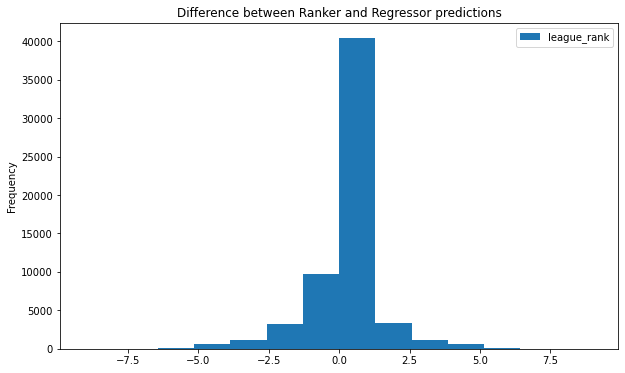

In [86]:
(preds_with_league-predictions_with_league).plot(kind='hist', bins=14, title='Difference between Ranker and Regressor predictions')

In [87]:
result = data_with_preds[['club_id', 'league_rank']]
result.to_csv('league_rank_predictions.csv',index=False)

# Conclusion
The best algorithm was the XGBRanker. However, all algorithms had a plateau at MAE=2. The forest overfitted the data and xgb was unable to learn more.

## Future improvements
If I had more time, I would do the following:
1. Create pipelines. The task was significantly harder without them.
2. Test neural networks.
3. Try to find clusters with KMeans.
4. Do target encoding.
5. Try to engineer additional features.
6. More delicately approach the outliers.